# Using vtreat with Unsupervised Problems and Non-Y-aware data treatment

## Preliminaries

Nina Zumel and John Mount
November 2019

Note: this is a description of the [`Python` version of `vtreat`](https://github.com/WinVector/pyvtreat), the same example for the [`R` version of `vtreat`](https://github.com/WinVector/vtreat) can be found [here](https://github.com/WinVector/vtreat/blob/master/Examples/Unsupervised/Unsupervised.md).

Load modules/packages.

In [1]:
import pkg_resources
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot as plt
import vtreat
import vtreat.util
import wvpy.util

numpy.random.seed(2019)

Generate example data. 

* `y` is a noisy sinusoidal plus linear function of the variable `x`
* Input `xc` is a categorical variable that represents a discretization of `y`, along with some `NaN`s
* Input `x2` is a pure noise variable with no relationship to the output
* Input `x3` is a constant variable

In [2]:
def make_data(nrows):
    d = pandas.DataFrame({'x':[0.1*i for i in range(500)]})
    d['y'] = numpy.sin(d['x']) + 0.01*d['x'] +  0.1*numpy.random.normal(size=d.shape[0])
    d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
    d['x2'] = numpy.random.normal(size=d.shape[0])
    d['x3'] = 1
    d.loc[d['xc']=='level_-1.0', 'xc'] = numpy.nan # introduce a nan level
    return d

d = make_data(500)

d.head()

,x,y,xc,x2,x3
0,0.0,-0.021768,level_-0.0,-0.704278,1
1,0.1,0.182979,level_0.0,1.508747,1
2,0.2,0.348797,level_0.5,0.048117,1
3,0.3,0.431707,level_0.5,-1.445366,1
4,0.4,0.357232,level_0.5,-0.037443,1


### Some quick data exploration

Check how many levels `xc` has, and their distribution (including `NaN`)

In [3]:
d['xc'].unique()

array(['level_-0.0', 'level_0.0', 'level_0.5', 'level_1.0', 'level_1.5',
       'level_-0.5', nan], dtype=object)

In [4]:
d['xc'].value_counts(dropna=False)

level_1.0     127
level_-0.5    125
level_0.5      86
level_0.0      50
level_-0.0     39
NaN            38
level_1.5      35
Name: xc, dtype: int64

## Build a transform appropriate for unsupervised (or non-y-aware) problems.

The `vtreat` package is primarily intended for data treatment prior to supervised learning, as detailed in the [Classification](https://github.com/WinVector/pyvtreat/blob/master/Examples/Classification/Classification.ipynb) and [Regression](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.ipynb) examples. In these situations, `vtreat` specifically uses the relationship between the inputs and the outcomes in the training data to create certain types of synthetic variables. We call these more complex synthetic variables *y-aware variables*. 

However, you may also want to use `vtreat` for basic data treatment for unsupervised problems, when there is no outcome variable. Or, you may not want to create any y-aware variables when preparing the data for supervised modeling. For these applications, `vtreat` is a convenient alternative to: `pandas.get_dummies()` or `sklearn.preprocessing.OneHotEncoder()`.

In any case, we still want training data where all the input variables are numeric and have no missing values or `NaN`s.

First create the data treatment transform object, in this case a treatment for an unsupervised problem.

In [5]:
transform = vtreat.UnsupervisedTreatment(
     cols_to_copy = ['y'],          # columns to "carry along" but not treat as input variables
)  

Use the training data `d` to fit the transform and the return a treated training set: completely numeric, with no missing values.

In [6]:
d_prepared = transform.fit_transform(d)

Now examine the score frame, which gives information about each new variable, including its type and which original variable it is  derived from. Some of the columns of the score frame (`y_aware`, `PearsonR`, `significance` and `recommended`) are not relevant to the unsupervised case; those columns are used by the Regression and Classification transforms.

In [7]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,recommended,vcount
0,xc_is_bad,xc,missing_indicator,False,True,NaN,NaN,True,1.0
1,x,x,clean_copy,False,True,NaN,NaN,True,2.0
2,x2,x2,clean_copy,False,True,NaN,NaN,True,2.0
3,xc_prevalence_code,xc,prevalence_code,False,True,NaN,NaN,True,1.0
4,xc_lev_level_1_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
5,xc_lev_level_-0_5,xc,indicator_code,False,True,NaN,NaN,True,7.0
6,xc_lev_level_0_5,xc,indicator_code,False,True,NaN,NaN,True,7.0
7,xc_lev_level_0_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
8,xc_lev_level_-0_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
9,xc_lev__NA_,xc,indicator_code,False,True,NaN,NaN,True,7.0


Notice that the variable `xc` has been converted to multiple variables: 

* an indicator variable for each possible level, including `NA` or missing (`xc_lev_level_*`)
* a variable indicating when `xc` was `NaN` in the original data (`xc_is_bad`)
* a variable that returns how prevalent this particular value of `xc` is in the training data (`xc_prevalence_code`)

Any or all of these new variables are available for downstream modeling.

Also note that the variable `x3` did not show up in the score frame, as it had no range (didn't vary), so the unsupervised treatment dropped it.

Let's look at the top of `d_prepared`, which includes all the new variables, plus `y` (and excluding `x3`).

In [8]:
d_prepared.head()

,y,xc_is_bad,x,x2,xc_prevalence_code,xc_lev_level_1_0,xc_lev_level_-0_5,xc_lev_level_0_5,xc_lev_level_0_0,xc_lev_level_-0_0,xc_lev__NA_,xc_lev_level_1_5
0,-0.021768,0.0,0.0,-0.704278,0.078,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.182979,0.0,0.1,1.508747,0.100,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.348797,0.0,0.2,0.048117,0.172,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.431707,0.0,0.3,-1.445366,0.172,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.357232,0.0,0.4,-0.037443,0.172,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Using the Prepared Data to Model

Of course, what we really want to do with the prepared training data is to model. 

### K-means clustering

Let's start with an unsupervised analysis: clustering.

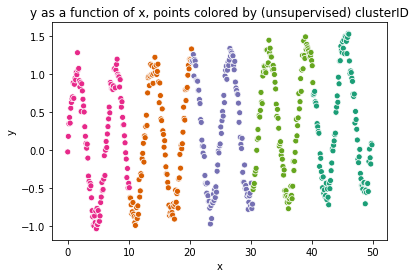

In [9]:
# don't use y to cluster
not_variables = ['y']
model_vars = [v for v in d_prepared.columns if v not in set(not_variables)]

import sklearn.cluster

d_prepared['clusterID'] = sklearn.cluster.KMeans(n_clusters = 5).fit_predict(d_prepared[model_vars])
d_prepared.clusterID

# colorbrewer Dark2 palette
mypalette = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']
ax = seaborn.scatterplot(x = "x", y = "y", hue="clusterID", 
                    data = d_prepared, 
                    palette=mypalette, 
                    legend=False)
ax.set_title("y as a function of x, points colored by (unsupervised) clusterID")
plt.show()

### Supervised modeling with non-y-aware variables

Since in this case we have an outcome variable, `y`, we can try fitting a linear regression model to `d_prepared`.

In [10]:
import sklearn.linear_model
import seaborn
import sklearn.metrics
import matplotlib.pyplot

not_variables = ['y', 'prediction', 'clusterID']
model_vars = [v for v in d_prepared.columns if v not in set(not_variables)]
fitter = sklearn.linear_model.LinearRegression()
fitter.fit(d_prepared[model_vars], d_prepared['y'])
print(fitter.intercept_)
{model_vars[i]: fitter.coef_[i] for i in range(len(model_vars))}

0.2663584367410494


{'xc_is_bad': -0.5725948709331847,
 'x': 0.0012979680156703069,
 'x2': 0.0003944391214530679,
 'xc_prevalence_code': -0.004434334546243255,
 'xc_lev_level_1_0': 0.717131899754422,
 'xc_lev_level_-0_5': -0.8133266363407938,
 'xc_lev_level_0_5': 0.21813583211202345,
 'xc_lev_level_0_0': -0.1831739973957961,
 'xc_lev_level_-0_0': -0.4133594109584157,
 'xc_lev__NA_': -0.5725948709331844,
 'xc_lev_level_1_5': 1.0471871837617448}

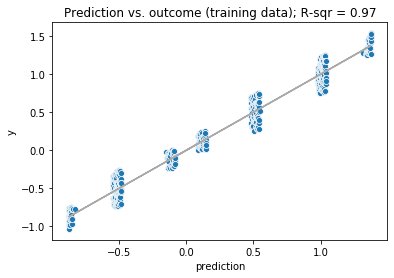

In [11]:
# now predict
d_prepared['prediction'] = fitter.predict(d_prepared[model_vars])

# get R-squared
r2 = sklearn.metrics.r2_score(y_true=d_prepared.y, y_pred=d_prepared.prediction)

title = 'Prediction vs. outcome (training data); R-sqr = {:04.2f}'.format(r2)

# compare the predictions to the outcome (on the training data)
ax = seaborn.scatterplot(x='prediction', y='y', data=d_prepared)
matplotlib.pyplot.plot(d_prepared.prediction, d_prepared.prediction, color="darkgray")
ax.set_title(title)
plt.show()

Now apply the model to new data.

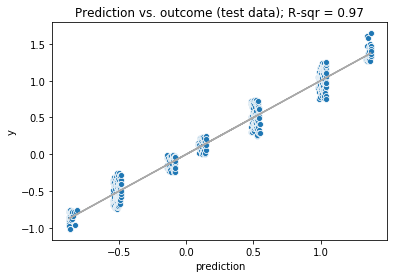

In [12]:
# create the new data
dtest = make_data(450)

# prepare the new data with vtreat
dtest_prepared = transform.transform(dtest)

# apply the model to the prepared data
dtest_prepared['prediction'] = fitter.predict(dtest_prepared[model_vars])

# get R-squared
r2 = sklearn.metrics.r2_score(y_true=dtest_prepared.y, y_pred=dtest_prepared.prediction)

title = 'Prediction vs. outcome (test data); R-sqr = {:04.2f}'.format(r2)

# compare the predictions to the outcome (on the training data)
ax = seaborn.scatterplot(x='prediction', y='y', data=dtest_prepared)
matplotlib.pyplot.plot(dtest_prepared.prediction, dtest_prepared.prediction, color="darkgray")
ax.set_title(title)
plt.show()

## Parameters for `UnsupervisedTreatment`

We've tried to set the defaults for all parameters so that `vtreat` is usable out of the box for most applications. Notice that the parameter object for unsupervised treatment defines a different set of parameters than the parameter object for supervised treatments (`vtreat.vtreat_parameters`).


In [13]:
vtreat.unsupervised_parameters()

{'coders': {'clean_copy',
  'indicator_code',
  'missing_indicator',
  'prevalence_code'},
 'indicator_min_fraction': 0.0,
 'user_transforms': [],
 'sparse_indicators': True,
 'missingness_imputation': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>}

**coders**: The types of synthetic variables that `vtreat` will (potentially) produce. See *Types of prepared variables* below.

**indicator_min_fraction**: By default, `UnsupervisedTreatment` creates indicators for all possible levels (`indicator_min_fraction=0`). If `indicator_min_fraction` > 0, then indicator variables (type `indicator_code`) are only produced for levels that are present at least `indicator_min_fraction` of the time. A consequence of this is that 1/`indicator_min_fraction` is the maximum number of indicators that will be produced for a given categorical variable. See the Example below.

**user_transforms**: For passing in user-defined transforms for custom data preparation. Won't be needed in most situations, but see [here](https://github.com/WinVector/pyvtreat/blob/master/Examples/UserCoders/UserCoders.ipynb) for an example of applying a GAM transform to input variables.

**sparse_indicators**: When True, use a (Pandas) sparse representation for indicator variables. This representation is compatible with `sklearn`; however, it may not be compatible with other modeling packages. When False, use a dense representation.

**missingness_imputation** The function or value that `vtreat` uses to impute or "fill in" missing numerical values. The default is `numpy.mean()`. To change the imputation function or use different functions/values for different columns, see the [Imputation example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Imputation/Imputation.ipynb).

### Example: Restrict the number of indicator variables

In [14]:
# calculate the prevalence of each level by hand
d['xc'].value_counts(dropna=False)/d.shape[0]

level_1.0     0.254
level_-0.5    0.250
level_0.5     0.172
level_0.0     0.100
level_-0.0    0.078
NaN           0.076
level_1.5     0.070
Name: xc, dtype: float64

In [15]:
transform_common = vtreat.UnsupervisedTreatment(
    cols_to_copy = ['y'],          # columns to "carry along" but not treat as input variables
    params = vtreat.unsupervised_parameters({
        'indicator_min_fraction': 0.2 # only make indicators for levels that show up more than 20% of the time
    })
)  

transform_common.fit_transform(d) # fit the transform
transform_common.score_frame_     # examine the score frame

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,recommended,vcount
0,xc_is_bad,xc,missing_indicator,False,True,NaN,NaN,True,1.0
1,x,x,clean_copy,False,True,NaN,NaN,True,2.0
2,x2,x2,clean_copy,False,True,NaN,NaN,True,2.0
3,xc_prevalence_code,xc,prevalence_code,False,True,NaN,NaN,True,1.0
4,xc_lev_level_1_0,xc,indicator_code,False,True,NaN,NaN,True,2.0
5,xc_lev_level_-0_5,xc,indicator_code,False,True,NaN,NaN,True,2.0


In this case, the unsupervised treatment only created levels for the two most common levels, which are both present more than 20% of the time. 

In unsupervised situations, this may only be desirable when there are an unworkably large number of possible levels (for example, when using ZIP code as a variable). It is more useful in conjunction with the y-aware variables produced by `NumericOutputTreatment`, `BinomialOutcomeTreatment`, or `MultinomialOutcomeTreatment`.

## Types of prepared variables

**clean_copy**: Produced from numerical variables: a clean numerical variable with no `NaNs` or missing values

**indicator_code**: Produced from categorical variables, one for each level: for each level of the variable, indicates if that level was "on"

**prevalence_code**: Produced from categorical variables: indicates how often each level of the variable was "on"

**missing_indicator**: Produced for both numerical and categorical variables: an indicator variable that marks when the original variable was missing or  `NaN`

### Example: Produce only a subset of variable types

In this example, suppose you only want to use indicators and continuous variables in your model; 
in other words, you only want to use variables of types (`clean_copy`, `missing_indicator`, and `indicator_code`), and no `prevalence_code` variables.

In [16]:
transform_thin = vtreat.UnsupervisedTreatment(
    cols_to_copy = ['y'],          # columns to "carry along" but not treat as input variables
    params = vtreat.unsupervised_parameters({
         'coders': {'clean_copy',
                    'missing_indicator',
                    'indicator_code',
                   }
    })
)  

transform_thin.fit_transform(d) # fit the transform
transform_thin.score_frame_


,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,recommended,vcount
0,xc_is_bad,xc,missing_indicator,False,True,NaN,NaN,True,1.0
1,x,x,clean_copy,False,True,NaN,NaN,True,2.0
2,x2,x2,clean_copy,False,True,NaN,NaN,True,2.0
3,xc_lev_level_1_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
4,xc_lev_level_-0_5,xc,indicator_code,False,True,NaN,NaN,True,7.0
5,xc_lev_level_0_5,xc,indicator_code,False,True,NaN,NaN,True,7.0
6,xc_lev_level_0_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
7,xc_lev_level_-0_0,xc,indicator_code,False,True,NaN,NaN,True,7.0
8,xc_lev__NA_,xc,indicator_code,False,True,NaN,NaN,True,7.0
9,xc_lev_level_1_5,xc,indicator_code,False,True,NaN,NaN,True,7.0


## Conclusion

In all cases (classification, regression, unsupervised, and multinomial classification) the intent is that `vtreat` transforms are essentially one liners.

The preparation commands are organized as follows:


 * **Regression**: [`Python` regression example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md), [`R` regression example, fit/prepare interface](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression_FP.md), [`R` regression example, design/prepare/experiment interface](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression.md).
 * **Classification**: [`Python` classification  example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Classification/Classification.md), [`R` classification example, fit/prepare interface](https://github.com/WinVector/vtreat/blob/master/Examples/Classification/Classification_FP.md), [`R` classification example, design/prepare/experiment interface](https://github.com/WinVector/vtreat/blob/master/Examples/Classification/Classification.md).
 * **Unsupervised tasks**: [`Python` unsupervised example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Unsupervised/Unsupervised.md), [`R` unsupervised example, fit/prepare interface](https://github.com/WinVector/vtreat/blob/master/Examples/Unsupervised/Unsupervised_FP.md), [`R` unsupervised example, design/prepare/experiment interface](https://github.com/WinVector/vtreat/blob/master/Examples/Unsupervised/Unsupervised.md).
 * **Multinomial classification**: [`Python` multinomial classification example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Multinomial/MultinomialExample.md), [`R` multinomial classification example, fit/prepare interface](https://github.com/WinVector/vtreat/blob/master/Examples/Multinomial/MultinomialExample_FP.md), [`R` multinomial classification example, design/prepare/experiment interface](https://github.com/WinVector/vtreat/blob/master/Examples/Multinomial/MultinomialExample.md).



Some `vtreat` common capabilities are documented here:

  * **Score Frame** [score_frame_](https://github.com/WinVector/pyvtreat/blob/master/Examples/ScoreFrame/ScoreFrame.md), using the `score_frame_` information.
  * **Cross Validation** [Customized Cross Plans](https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md), controlling the cross validation plan.

These current revisions of the examples are designed to be small, yet complete.  So as a set they have some overlap, but the user can rely mostly on a single example for a single task type.

